Stephanie

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.preprocessing import MinMaxScaler
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/stephanier/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [105]:
data = pd.read_csv("/Users/stephanier/Desktop/time/Youtube-forecasting/data/youtube_econ.csv",index_col=0)

In [106]:
#get just the date and views
daily_views = data[['Date','views']]
len(daily_views)
daily_views.index = pd.to_datetime(daily_views.Date)
daily_views = daily_views.drop(['Date'], axis=1)

In [4]:
daily_views.head()

,views
Date,
2017-11-14,185435246
2017-11-15,212445216
2017-11-16,227365391
2017-11-17,193541711
2017-11-18,196846875


In [107]:
values = daily_views['views'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(values)

In [108]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

139 69


In [109]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0111
Epoch 2/100
 - 0s - loss: 0.0057
Epoch 3/100
 - 0s - loss: 0.0051
Epoch 4/100
 - 0s - loss: 0.0047
Epoch 5/100
 - 0s - loss: 0.0043
Epoch 6/100
 - 0s - loss: 0.0038
Epoch 7/100
 - 0s - loss: 0.0034
Epoch 8/100
 - 0s - loss: 0.0029
Epoch 9/100
 - 0s - loss: 0.0025
Epoch 10/100
 - 0s - loss: 0.0021
Epoch 11/100
 - 0s - loss: 0.0019
Epoch 12/100
 - 0s - loss: 0.0015
Epoch 13/100
 - 0s - loss: 0.0014
Epoch 14/100
 - 0s - loss: 0.0013
Epoch 15/100
 - 0s - loss: 0.0012
Epoch 16/100
 - 0s - loss: 0.0011
Epoch 17/100
 - 0s - loss: 0.0011
Epoch 18/100
 - 0s - loss: 0.0011
Epoch 19/100
 - 0s - loss: 0.0011
Epoch 20/100
 - 0s - loss: 0.0011
Epoch 21/100
 - 0s - loss: 0.0010
Epoch 22/100
 - 0s - loss: 0.0010
Epoch 23/100
 - 0s - loss: 0.0010
Epoch 24/100
 - 0s - loss: 0.0011
Epoch 25/100
 - 0s - loss: 0.0010
Epoch 26/100
 - 0s - loss: 0.0011
Epoch 27/100
 - 0s - loss: 0.0010
Epoch 28/100
 - 0s - loss: 0.0010
Epoch 29/100
 - 0s - loss: 0.0011
Epoch 30/100
 - 0s - lo

In [110]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 34032428.89 RMSE
Test Score: 90389924.75 RMSE


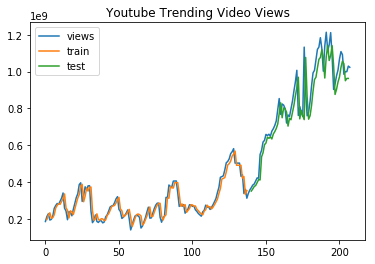

In [115]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = 'views')
plt.plot(trainPredictPlot, label ='train')
plt.plot(testPredictPlot,label = 'test')
plt.title('Youtube Trending Video Views')
plt.legend()
plt.show()

In [22]:
import scipy

In [26]:
daily_views.head()

,views
Date,
2017-11-14,185435246
2017-11-15,212445216
2017-11-16,227365391
2017-11-17,193541711
2017-11-18,196846875


In [27]:
daily_views.to_csv('latest.csv')

In [10]:
from pandas import Series
series = Series.from_csv('latest.csv', header=0)

In [11]:
from pandas import Series
series = Series.from_csv('latest.csv', header=0)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 196, Validation 12


In [12]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller

# create a differe
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

series = Series.from_csv('dataset.csv')
X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')

ADF Statistic: -4.145927
p-value: 0.000812
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


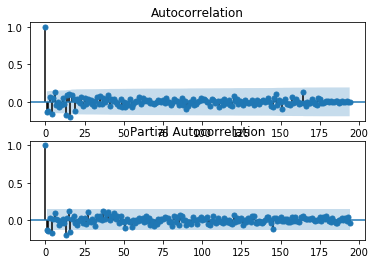

In [13]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [97]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
series = np.log(series)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.67)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,2,1))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/stephanier/anaconda/lib/pyt

>Predicted=20.049, Expected= 20
>Predicted=20.049, Expected= 20
>Predicted=20.049, Expected= 20
>Predicted=19.891, Expected= 20
>Predicted=19.910, Expected= 20
>Predicted=19.640, Expected= 20


/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=19.704, Expected= 20
>Predicted=19.558, Expected= 20
>Predicted=19.639, Expected= 20
>Predicted=19.694, Expected= 20
>Predicted=19.729, Expected= 20
>Predicted=19.767, Expected= 20
>Predicted=19.783, Expected= 20
>Predicted=19.825, Expected= 20
>Predicted=19.867, Expected= 20
>Predicted=19.863, Expected= 20
>Predicted=20.136, Expected= 20
>Predicted=20.178, Expected= 20
>Predicted=20.255, Expected= 20
>Predicted=20.271, Expected= 20
>Predicted=20.322, Expected= 20
>Predicted=20.312, Expected= 20
>Predicted=20.323, Expected= 20
>Predicted=20.306, Expected= 20
>Predicted=20.348, Expected= 20
>Predicted=20.368, Expected= 20
>Predicted=20.393, Expected= 20
>Predicted=20.428, Expected= 20
>Predicted=20.510, Expected= 21
>Predicted=20.585, Expected= 20
>Predicted=20.477, Expected= 21
>Predicted=20.548, Expected= 21
>Predicted=20.541, Expected= 20
>Predicted=20.517, Expected= 20
>Predicted=20.410, Expected= 20
>Predicted=20.470, Expected= 20
>Predicted=20.459, Expected= 20
>Predict

/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [98]:
#change predictions back to original units to compare models
pred = np.exp(predictions)
check = np.exp(test)
#pred = format(pred, 'f')
predy = []
checky = []
#type(pred)
#c = np.concatenate(pred)
#print('%f' % pred)
for element in pred:
    val = '%i' % element
    predy.append(float(val))
#get the rmse for the test data    
for element in check:
    val = '%i' % element
    checky.append(float(val))
predy

from sklearn.metrics import mean_squared_error
from math import sqrt
#get rmse of test data
rms = sqrt(mean_squared_error(checky, predy))

In [72]:
rms


85801576.64324833

In [87]:
len(train)

131

In [99]:
#check the rms on the training data
forecast = model_fit.predict()
predy = forecast[0:131]

/Users/stephanier/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [100]:
#change predictions back to original units to compare models
pred2 = np.exp(predy)
check2 = np.exp(train)
#pred = format(pred, 'f')
predy2 = []
checky2 = []
#type(pred)
#c = np.concatenate(pred)
#print('%f' % pred)
for element in pred2:
    val = '%i' % element
    predy2.append(float(val))
#get the rmse for the test data    
for element in check2:
    val = '%i' % element
    checky2.append(float(val))

from sklearn.metrics import mean_squared_error
from math import sqrt
#get rmse of test data
rms = sqrt(mean_squared_error(checky2, predy2))

In [101]:
rms

295440645.46641815

In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.67)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
series = np.log(series)
# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.885
ARIMA(0, 0, 1) MSE=0.497
ARIMA(0, 1, 0) MSE=0.103
ARIMA(0, 1, 1) MSE=0.107
ARIMA(0, 1, 2) MSE=0.107
ARIMA(0, 1, 3) MSE=0.110
ARIMA(0, 1, 4) MSE=0.110
ARIMA(0, 1, 5) MSE=0.109
ARIMA(0, 1, 6) MSE=0.118
ARIMA(0, 1, 7) MSE=0.121
ARIMA(0, 1, 8) MSE=0.122
ARIMA(0, 1, 9) MSE=0.122


In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=391135007.088
ARIMA(0, 0, 1) MSE=220978449.186
ARIMA(0, 1, 0) MSE=70194511.424
ARIMA(0, 1, 1) MSE=70701228.220
ARIMA(0, 1, 2) MSE=71248517.798
ARIMA(0, 1, 3) MSE=73170176.365
ARIMA(0, 1, 4) MSE=72626115.559
ARIMA(0, 1, 5) MSE=73771448.489
ARIMA(0, 1, 6) MSE=74434488.587
ARIMA(0, 1, 7) MSE=78091286.106
ARIMA(0, 1, 8) MSE=78617359.507
ARIMA(0, 1, 9) MSE=76395499.626
ARIMA(0, 1, 10) MSE=77643388.542
ARIMA(0, 1, 11) MSE=78578169.991
ARIMA(0, 1, 12) MSE=78175665.788
ARIMA(0, 2, 0) MSE=108158546.502
ARIMA(0, 2, 1) MSE=74557653.766
ARIMA(1, 0, 0) MSE=72092889.987
ARIMA(1, 1, 0) MSE=71384449.890
ARIMA(1, 2, 0) MSE=96746778.623
ARIMA(1, 2, 1) MSE=75816363.633
ARIMA(1, 2, 3) MSE=75910780.787
ARIMA(2, 1, 0) MSE=71607748.670
ARIMA(2, 2, 0) MSE=86177092.640
ARIMA(2, 2, 1) MSE=75886354.571
ARIMA(3, 1, 0) MSE=72032834.504
ARIMA(3, 2, 0) MSE=88014024.794
ARIMA(3, 2, 1) MSE=76044531.389
ARIMA(4, 1, 0) MSE=73832474.278
ARIMA(4, 2, 0) MSE=84214164.464
ARIMA(4, 2, 1) MSE=76511771.451
AR